# Homework 03 - Sebastiano Zagatti
## Exercise 1:
Let $\theta_1$ and $\theta_2$ be real valued parameters in $[0,1]$ and consider the generative model
\begin{align*}
\theta_1 &\sim \theta_1\text{-prior}\\
\theta_2 &\sim \theta_2\text{-prior}\\
\hat{y} &= \frac{\theta_1+x^2}{\theta_2\cdot x}\\
y &\sim \mathcal{N} (\hat{y}, 1)
\end{align*}

a. Use pyro to implement the model as a function `model(theta1_prior, theta2_prior, x, obs)`, where `theta1_prior` and `theta2_prior` are pyro.distributions objects, `x` and `obs` are torch tensors, and draws from the normal distribution are conditioned on `obs`.

b. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$ (e.g. suitably rescaled Normal or Beta distributions)  and use HMC or NUTS algorithm to find their posterior distributions given the observations

\begin{align*}
x&=(47,87,20,16,38,5)\\
y&=(58.76, 108.75,  25.03,  20.03,  47.51,  6.37).
\end{align*}


c. Discuss how different prior distributions lead to different estimates of $\theta_1$ and $\theta_2$. Comment on the convergence checks and plot the posterior distributions. 

#### Solution
a. Pyro implementation of `model`:

In [1]:
!pip install pyro-ppl

In [2]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [3]:
def model(theta1_prior : pyro.distributions, theta2_prior : pyro.distributions, x : torch.tensor, obs : torch.tensor):
  theta_1 = pyro.sample('theta_1', theta1_prior)
  theta_2 = pyro.sample('theta_2', theta2_prior)
  y_hat = (theta_1 + x**2)/(theta_2 * x)
  y = pyro.sample("y", dist.Normal(y_hat, 1.), obs=obs)
  return y

b. Let's first define the tensors for the observations:

In [4]:
x = torch.tensor([47.0, 87.0, 20.0, 16.0, 38.0, 5.0])
y = torch.tensor([58.76, 108.75, 25.03, 20.03, 47.51, 6.37])

We also introduce two auxiliary function in order to avoid code duplication:

In [5]:
def doing_mcmc(model, theta1_dist, theta2_dist, xx, yy, samples, warmup, chains):
  kernel = HMC(model)
  mcmc = MCMC(kernel, num_samples=samples, warmup_steps=warmup, num_chains=chains)

  posterior = mcmc.run(theta1_prior = theta1_dist, theta2_prior = theta2_dist, x = xx, obs = yy)
  mcmc.summary()
  
  mcmc_samples = mcmc.get_samples(group_by_chain=True)

  n_chains = mcmc.num_chains
  n_samples = mcmc.num_samples
  print("chains = ", n_chains, "samples = ", n_samples)

  fig, ax = plt.subplots(len(mcmc_samples), n_chains, figsize=(15,8))
  for i, key in enumerate(mcmc_samples.keys()):
    for j, chain in enumerate(mcmc_samples[key]):
      sns.lineplot(x=range(n_samples), y=chain, ax=ax[i][j])
      ax[i][j].set_title(key + " chain "+str(i+1))

  for key in mcmc_samples.keys():
    print("expected ", key, " = ", mcmc_samples[key].mean().item())

  fig, ax = plt.subplots(1, 2, figsize=(15,8))
  for i, key in enumerate(mcmc_samples.keys()):
    sns.distplot(mcmc_samples[key], ax = ax[i])
    ax[i].set_title("P(" + key + " | y = obs)")
    ax[i].set_xlabel(xlabel = key)

In [6]:
def doing_nuts(model, theta1_dist, theta2_dist, xx, yy, samples, warmup, chains):
  kernel = NUTS(model)
  mcmc = MCMC(kernel, num_samples=samples, warmup_steps=warmup, num_chains=chains)

  posterior = mcmc.run(theta1_prior = theta1_dist, theta2_prior = theta2_dist, x = xx, obs = yy)
  mcmc.summary()
  
  mcmc_samples = mcmc.get_samples(group_by_chain=True)

  n_chains = mcmc.num_chains
  n_samples = mcmc.num_samples
  print("chains = ", n_chains, "samples = ", n_samples)

  fig, ax = plt.subplots(len(mcmc_samples), n_chains, figsize=(15,8))
  for i, key in enumerate(mcmc_samples.keys()):
    for j, chain in enumerate(mcmc_samples[key]):
      sns.lineplot(x=range(n_samples), y=chain, ax=ax[i][j])
      ax[i][j].set_title(key + " chain "+str(i+1))

  for key in mcmc_samples.keys():
    print("expected ", key, " = ", mcmc_samples[key].mean().item())

  fig, ax = plt.subplots(1, 2, figsize=(15,8))
  for i, key in enumerate(mcmc_samples.keys()):
    sns.distplot(mcmc_samples[key], ax = ax[i])
    ax[i].set_title("P(" + key + " | y = obs)")
    ax[i].set_xlabel(xlabel = key)

We are now going to show different choices of prior distributions for $\theta_1$ and $\theta_2$, using both MCMC and NUTS to find their posterior distribution given the observations.

- **MCMC with BETA priors**:

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Sample [2]: 100%|██████████| 1500/1500 [00:47, 31.40it/s, step size=6.51e-01, acc. prob=0.914]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.54      0.36      0.57      0.03      1.00    525.53      1.01
   theta_2      0.80      0.01      0.80      0.79      0.81     90.52      1.03

Number of divergences: 0
chains =  3 samples =  500
expected  theta_1  =  0.5356252789497375
expected  theta_2  =  0.8002839088439941


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


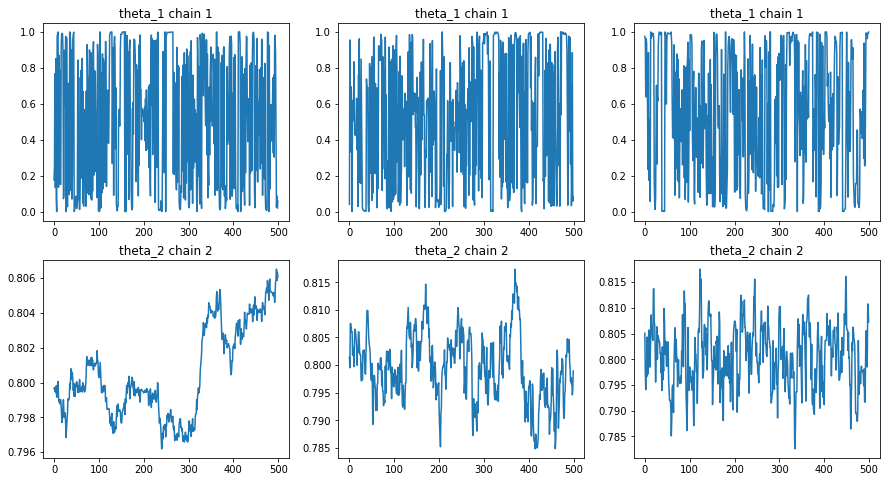

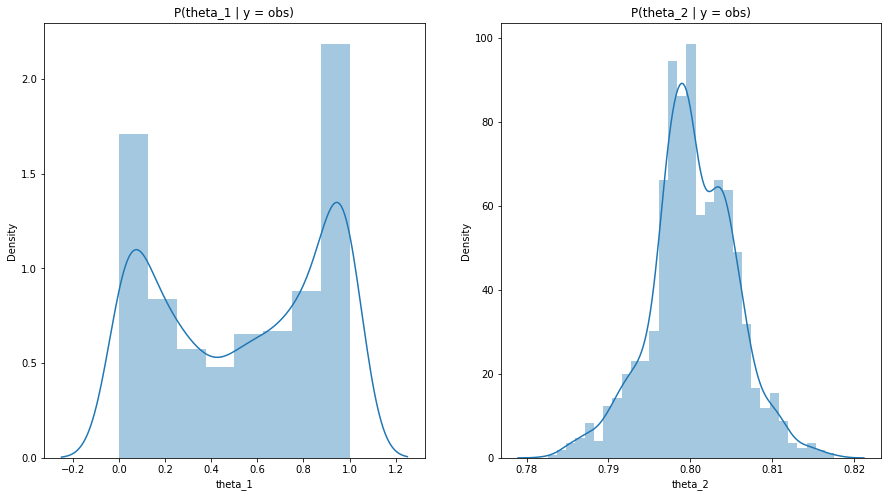

In [8]:
doing_mcmc(model = model, theta1_dist = dist.Beta(.5, .5), theta2_dist = dist.Beta(5.0, 1.0), xx = x, yy = y, samples = 500, warmup=1000, chains=3)

- **NUTS with BETA priors**:

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Sample [2]: 100%|██████████| 1500/1500 [00:20, 73.32it/s, step size=6.96e-01, acc. prob=0.915] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.50      0.36      0.50      0.00      0.97    911.15      1.00
   theta_2      0.80      0.01      0.80      0.79      0.81   1044.51      1.00

Number of divergences: 0
chains =  3 samples =  500
expected  theta_1  =  0.49588146805763245
expected  theta_2  =  0.8002444505691528


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


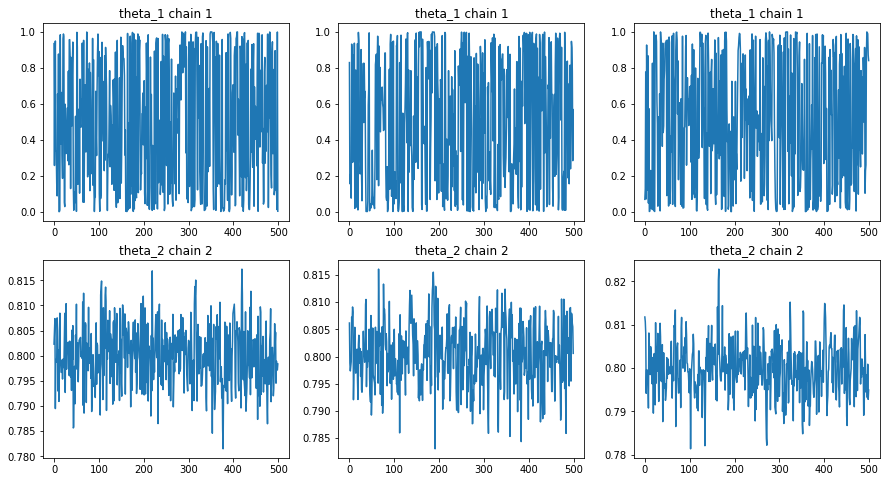

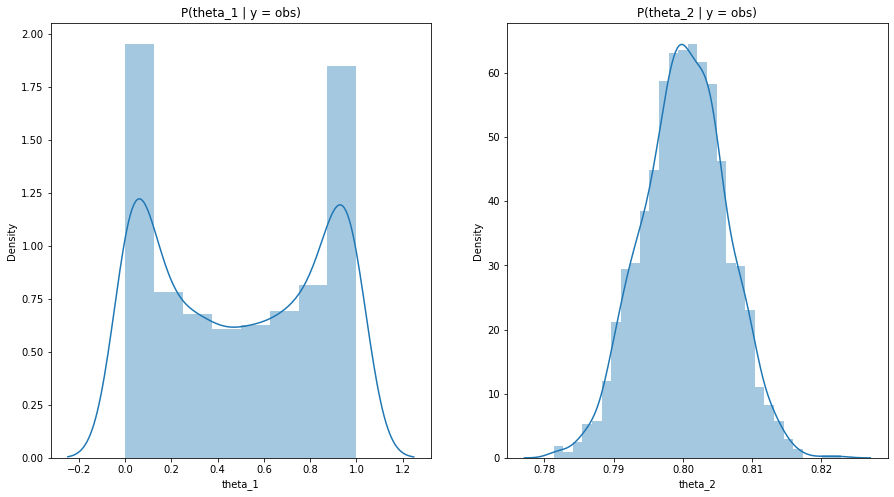

In [9]:
doing_nuts(model = model, theta1_dist = dist.Beta(.5, .5), theta2_dist = dist.Beta(5.0, 1.0), xx = x, yy = y, samples = 500, warmup=1000, chains=3)

- **MCMC with Uniform priors**:

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Warmup [2]:   7%|▋         | 106/1500 [05:48,  3.29s/it, step size=1.83e-05, acc. prob=0.778]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.49      0.29      0.47      0.00      0.89    246.65      1.01
   theta_2      0.80      0.01      0.80      0.79      0.81    149.17      1.01

Number of divergences: 0
chains =  3 samples =  500
expected  theta_1  =  0.4872201681137085
expected  theta_2  =  0.8000463843345642


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


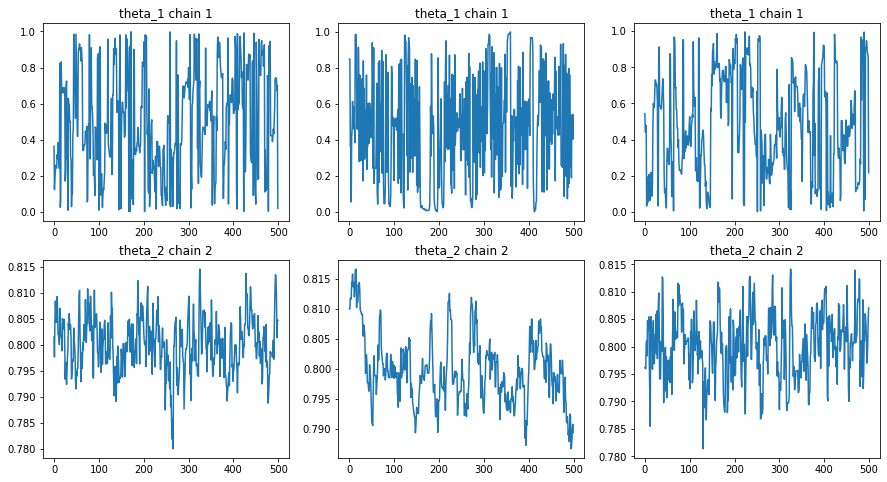

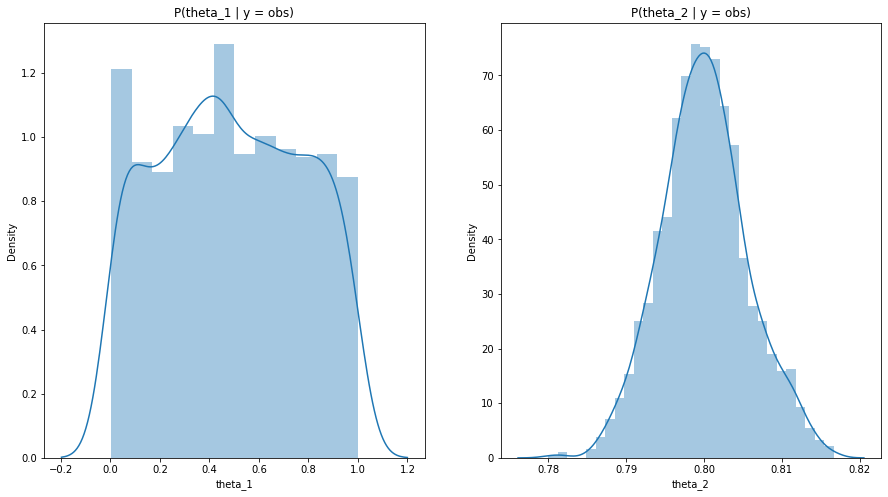

In [15]:
doing_mcmc(model = model, theta1_dist = dist.Uniform(0.,1.), theta2_dist = dist.Uniform(0.,1.), xx = x, yy = y, samples = 500, warmup=1000, chains=3)

- **NUTS with Uniform priors**:

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Sample [2]: 100%|██████████| 1500/1500 [00:14, 103.45it/s, step size=8.39e-01, acc. prob=0.914]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.50      0.29      0.51      0.00      0.89   1296.32      1.00
   theta_2      0.80      0.01      0.80      0.79      0.81   1258.25      1.00

Number of divergences: 0
chains =  3 samples =  500
expected  theta_1  =  0.5046466588973999
expected  theta_2  =  0.8002350926399231


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


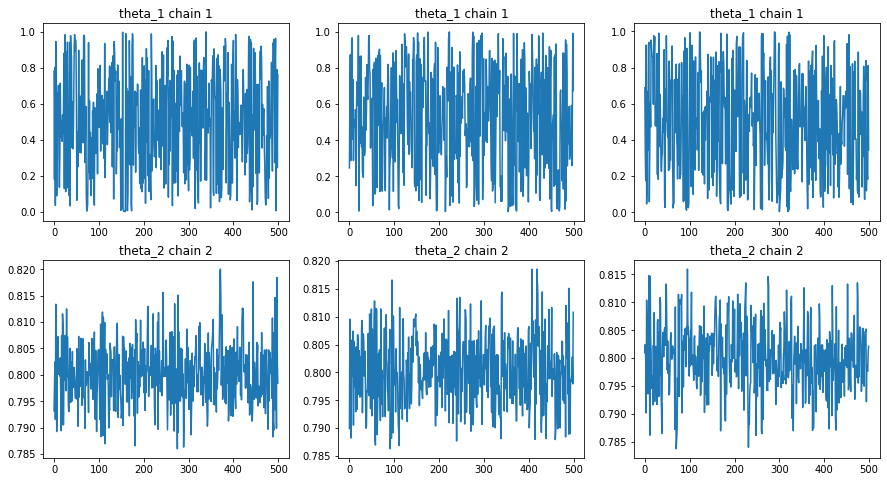

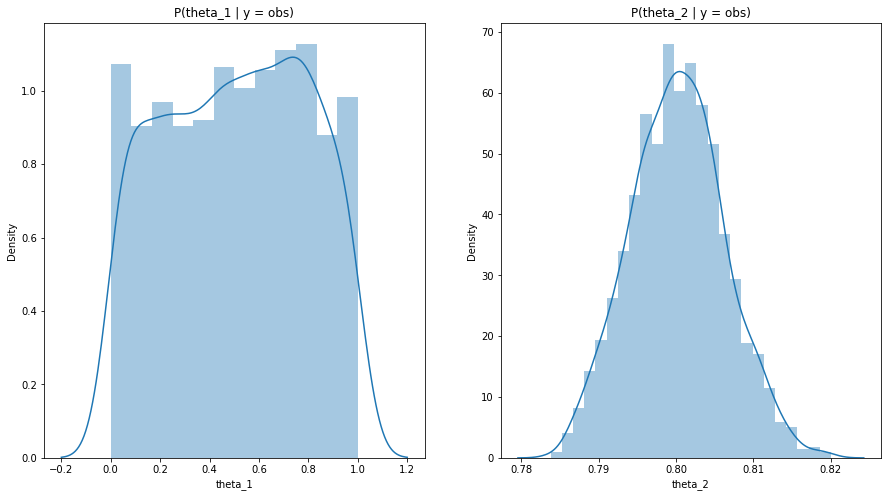

In [16]:
doing_nuts(model = model, theta1_dist = dist.Uniform(0.,1.), theta2_dist = dist.Uniform(0.,1.), xx = x, yy = y, samples = 500, warmup=1000, chains=3)

- **MCMC with Rescaled Normal priors**:

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Sample [2]: 100%|██████████| 1500/1500 [01:14, 20.01it/s, step size=8.82e-01, acc. prob=0.974] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.48      0.17      0.48      0.21      0.77     61.42      1.03
   theta_2     -6.98      0.07     -6.96     -7.11     -6.89      2.68      1.64

Number of divergences: 0
chains =  3 samples =  500
expected  theta_1  =  0.47862130403518677
expected  theta_2  =  -6.981785297393799


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


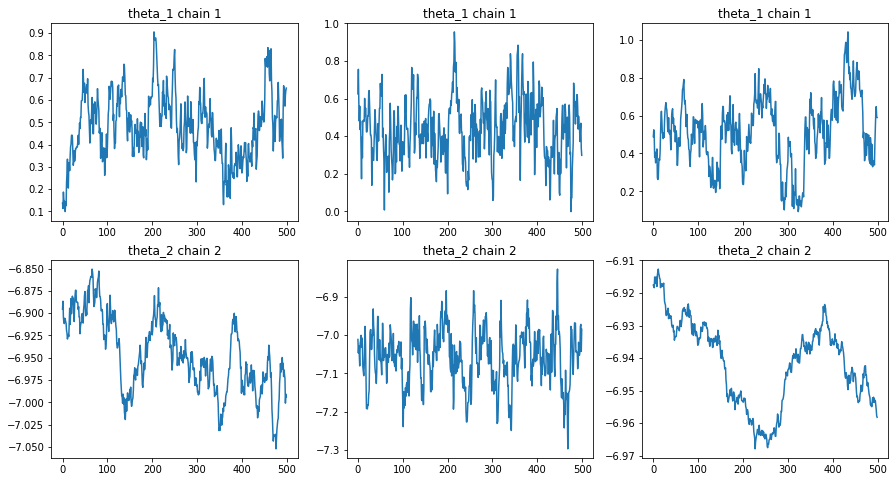

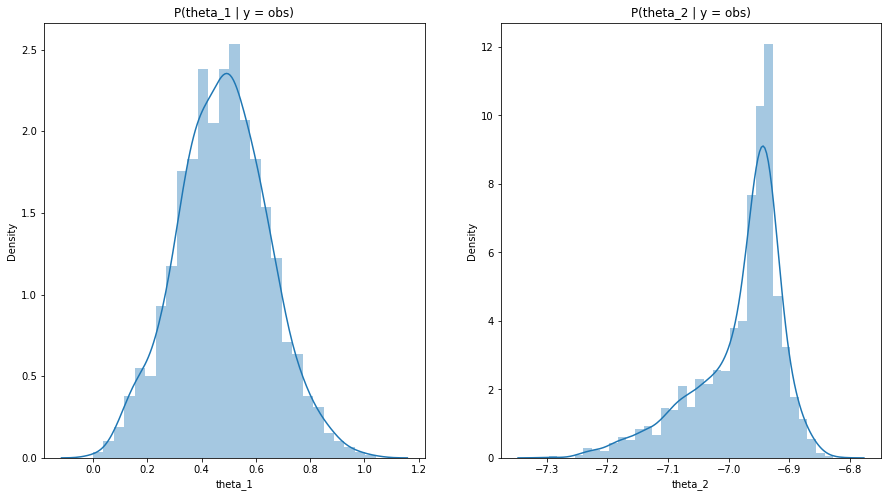

In [18]:
doing_mcmc(model = model, theta1_dist = dist.Normal(0.5,0.15), theta2_dist = dist.Normal(0.5,0.15), xx = x, yy = y, samples = 500, warmup=1000, chains=3)

- **NUTS with Rescaled Normal priors**:

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Sample [2]: 100%|██████████| 1500/1500 [00:08, 175.07it/s, step size=8.48e-01, acc. prob=0.915]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.49      0.14      0.49      0.27      0.73    848.98      1.01
   theta_2     -1.81      3.69      0.80     -7.08      0.82      1.50     80.26

Number of divergences: 0
chains =  3 samples =  500
expected  theta_1  =  0.4885198175907135
expected  theta_2  =  -1.8113927841186523


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


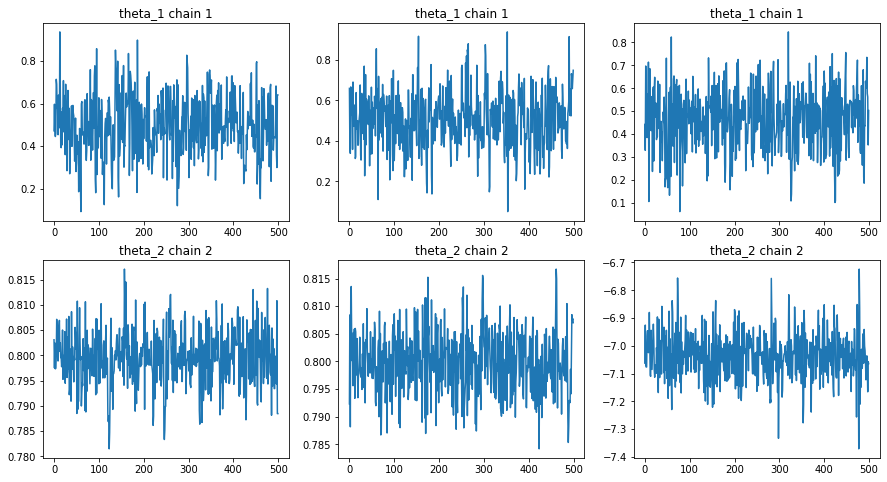

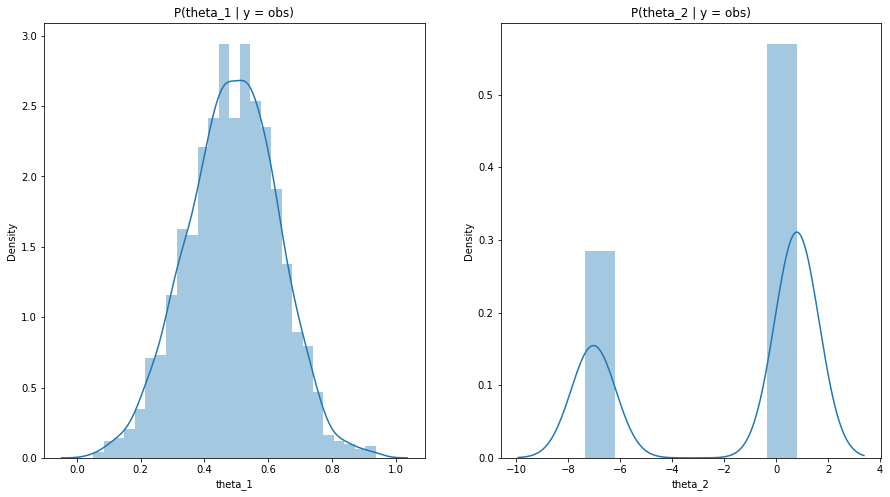

In [19]:
doing_nuts(model = model, theta1_dist = dist.Normal(0.5,0.15), theta2_dist = dist.Normal(0.5, 0.15), xx = x, yy = y, samples = 500, warmup=1000, chains=3)

c. Using either a beta distribution or a uniform distribution as priors for $\theta_1$ and $\theta_2$ lead to similar results. In particular, if we compare the estimates obtained using the HMC algorithm we have that the beta prior gives a better estimate of $\theta_1$, since the r-value is the same (1.01) and n-eff is higher; however, regarding $\theta_2$ we have that using a uniform distribution gives better results since we have a lower r-value and a higher n-eff, so given this last consideration we can conclude that using a uniform prior gives better results in this case.

If we consider the results obtained using the NUTS algorithm we have that we get the same estimates independently on the prior used, however if we look at the convergence checks we can see that again we get better results for both values by using a uniform prior distribution.

Finally, we can see that using a rescaled normal distribution we get some strange results for the $\theta_2$ parameter: even though we get convergence we can see that the r-values are really far from 1 in both algorithms. $\theta_1$ is estimated just fine, especially by using the NUTS algorithm.

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$
    
a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler function which takes as inputs the parameter `rho`, the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

#### Solution

a. From the properties of the multivariate normal distribution in the bivariate case we have that in general we can write:

\begin{align*}
x_1 | x_2 &\sim \mathcal{N}\left( \mu_1+\frac{\rho}{\sigma_2^2}(x_2-\mu_2), \sigma_1^2-\frac{\rho^2}{\sigma_2^2
}\right) \\
x_2 | x_1 &\sim \mathcal{N}\left( \mu_2+\frac{\rho}{\sigma_1^2}(x_1-\mu_1), \sigma_2^2-\frac{\rho^2}{\sigma_1^2}\right)
\end{align*}

In our case this can be simplified to:

\begin{align*}
x_1 | x_2 &\sim \mathcal{N}\left( \rho x_2, 1-\rho^2 \right)
\\
x_2 | x_1 &\sim \mathcal{N}\left( \rho x_1, 1-\rho^2 \right)
\end{align*}

In [20]:
def gibbs_sampler(rho, warmup, iters):
    x1 = torch.zeros(warmup+iters, 1)
    x2 = torch.zeros(warmup+iters, 1)
    
    # starting value for x_2
    x2[0] = pyro.sample('x2', dist.Normal(0,1))
    
    # starting value p(x_1 | x_2^0)
    x1[0] = pyro.sample('x1', dist.Normal(rho*(x2[0].item()), np.sqrt(1-rho**2)))
    
    # iterations
    for i in range(1, warmup+iters):
        
        # first draw
        x2[i] = pyro.sample('x2', dist.Normal(rho*x1[i-1].item(), np.sqrt(1-rho**2)))
        
        #second draw
        x1[i] = pyro.sample('x1', dist.Normal(rho*x2[i].item(), np.sqrt(1-rho**2)))
        
    return x1[warmup:-1], x2[warmup:-1]

Let's check that this works:

In [21]:
x1, x2 = gibbs_sampler(0.96, 1000, 500)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


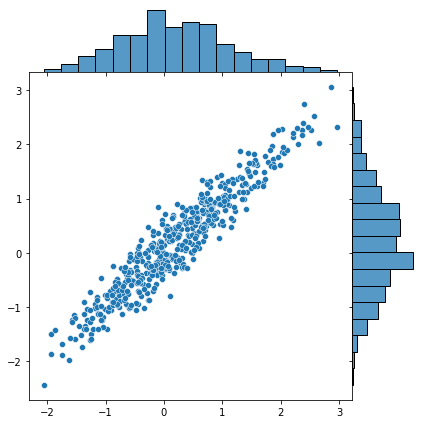

In [23]:
sns.jointplot(np.array(x1[:, 0]), np.array(x2[:, 0]), space = 0)

b. Let's define the general case of the previous function:

In [24]:
def gibbs_sampler_general(start, rho, warmup, iters, mu1 = 0, mu2 = 0):
    x1 = torch.zeros(warmup+iters, 1)
    x2 = torch.zeros(warmup+iters, 1)
    
    x2[0] = start
    
    # starting value p(x_1 | x_2^0)
    x1[0] = pyro.sample('x1', dist.Normal(mu1 + rho*(x2[0].item()-mu2), np.sqrt(1-rho**2)))
    
    # iterations
    for i in range(1, warmup+iters):
        
        # first draw
        x2[i] = pyro.sample('x2', dist.Normal(mu2 + rho*(x1[i-1].item()-mu1), np.sqrt(1-rho**2)))
        
        #second draw
        x1[i] = pyro.sample('x1', dist.Normal(mu1 + rho*(x2[i].item()-mu2), np.sqrt(1-rho**2)))
        
    return x1[warmup:-1], x2[warmup:-1]

We need to re-run the NUTS algorithm since we used functions in the previous exercise:

In [25]:
theta1_dist = dist.Uniform(0.,1.)
theta2_dist = dist.Uniform(0.,1.)
xx = x
yy = y
samples = 3000
warmup=1500
chains=3

kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=samples, warmup_steps=warmup, num_chains=chains)
posterior = mcmc.run(theta1_prior = theta1_dist, theta2_prior = theta2_dist, x = xx, obs = yy)
mcmc.summary()

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Sample [2]: 100%|██████████| 4500/4500 [00:31, 140.92it/s, step size=8.22e-01, acc. prob=0.909]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.50      0.29      0.51      0.03      0.93   7650.97      1.00
   theta_2      0.80      0.01      0.80      0.79      0.81   7707.00      1.00

Number of divergences: 0


Let's get all the parameters for the distribution of $\theta_1$ and $\theta_2$:

In [26]:
theta1_sample = mcmc.get_samples()['theta_1']
theta2_sample = mcmc.get_samples()['theta_2']

mu1 = float(theta1_sample.mean())
mu2 = float(theta2_sample.mean())

print("Mu_1 = ", mu1, "Mu_2 = ", mu2, "\n")

sigma = np.corrcoef(np.array([np.array(theta1_sample), np.array(theta2_sample)]))
print("Covariance Matrix: ")
print(sigma)

estimated_rho = sigma[0,1]

Mu_1 =  0.5024603009223938 Mu_2 =  0.8001969456672668 

Covariance Matrix: 
[[1.         0.02629717]
 [0.02629717 1.        ]]


Sampling and plotting:

In [27]:
theta1_sample_gibbs,  theta2_sample_gibbs = gibbs_sampler_general(0.5, estimated_rho, 1500, 3000, mu1 = mu1, mu2 = mu2)

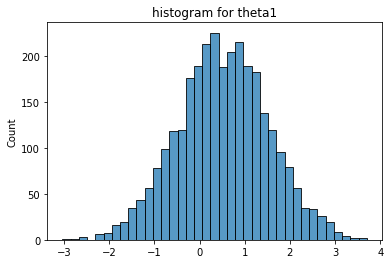

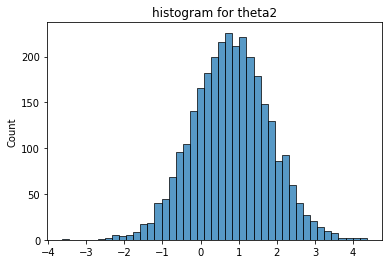

In [28]:
sns.histplot(theta1_sample_gibbs[:, 0])
plt.title("histogram for theta1")
plt.show()
sns.histplot(theta2_sample_gibbs[:, 0])
plt.title("histogram for theta2")
plt.show()